# Generalization - GATR General vs Specific

Building a single model (GATR General) that can handle a diverse range of problem setups (different number of tasks, agents, discretization level)
Upon illustrating our method in 1 example, we would like to show the full distributions of the solution. We aim to show 3 plots here:
- (a) Comparison of average mission times (mean across 30,000 test scenarios) achieved by GATR-General (purple lines) and GATR-Specific (dark blue) across varying numbers of tasks, agents and task discretization levels; both closely track NOpt-LKH3 performance (dashed grey lines) and are much smaller than randomly
generated missions (represented by Med-S, solid grey lines). 
- (b) Comparison of percentage increase in mission time of GATR-General (purple) and GATR-Specific (dark blue) relative to LKH3 as a function of increasing problem size (number of sub-tasks per agent). Coloured lines and shaded regions show mean and standard deviations respectively, with average across whole dataset indicated by coloured text. The normalized runtime rtˆ of GATR-General is also shown against the right-hand y-axis by grey lines with circle markers (GPU runtimes) and star markers (Raspberry Pi runtimes).

This notebook assumes that the following sets of experiments have already been collected (indicated by `Collected: {path}` below) using the scripts in `../run`. For instructions on how to run these scripts, please refer to `../example`. This notebook focuses solely on visualizing the results.

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import HTML
from ast import literal_eval
import copy
from pathlib import Path
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator
from matplotlib.collections import PolyCollection

from graph_attention_replanner.config import LogFileConfig

plt.rcParams["font.family"] = "sans-serif"
CB_color_cycle_hex = ['#8c2b72', '#3B4992', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#B3B3B3', '#e41a1c', '#dede00']
palette = sns.color_palette(CB_color_cycle_hex)
os.system("mkdir -p ../../cache/plots")

0

In [2]:
method_presentable = {
    "gat_gen": "GATR-General",
    "gat": "GATR-Specific",
    "lkh": "NOpt-LKH3",
    "random": "Med-S",
}

problem_presentable = {
    1: "mTSP",
    2: "mTSP + Vary Task Time",
    3: "mTSP + Multiple Start Loc.",
    4: "mTSP + Vary Task Time \n+ Multiple Start Loc.",
    5: "mTSP + Vary Task Time \n+ Multiple Start Loc. \n+ Collaborative Tasking",
}

method_details = {
    "gat": "gat_gpu_batch",
    "gat_gen": "gat_gen_gpu_batch",
    "lkh": "lkh_gpu",
    "random": "random_101_cpu"
}

base_arg = {
    "mtsp_problem_type": 5,
    "batch_size": 10000,
}

num_task_list = [2,4,6]
num_agent_list = [2,4,6]
discretize_level_list = [1,2,4]

data_seeds = [10,11,12]
# Which model to evaulate on which data, here model 0 evaulate on data 10
method_seeds = {
    10: 0,
    11: 1,
    12: 2,
}

### Load Main Experiments

In [3]:
def remove_stem(path):
    parts = Path(path).parts
    idx = parts.index("cache")
    relative_path = Path(*parts[idx:]) 
    return relative_path

df_list = []
for data_seed in data_seeds:
    for num_task in num_task_list:
        for num_agent in num_agent_list:
            for discretize_level in discretize_level_list:
                num_node = num_task*discretize_level
                for method in ["gat", "lkh", "gat_gen", "random"]:
                    cfg = LogFileConfig(
                        base_arg["mtsp_problem_type"],
                        num_node,
                        num_task,
                        num_task,
                        discretize_level,
                        discretize_level,
                        num_agent,
                        num_agent,
                        base_arg["batch_size"],
                        read_only=True,
                    )
                    num_exp = 1 if (method == "gat" or method == "gat_gen" or method == "random") else base_arg["batch_size"]
                    method_seed = method_seeds[data_seed] if (method == "gat" or method == "gat_gen") else None
                    path = cfg.get_result_logfilename(
                        method=method_details[method],
                        format="csv",
                        num_exp=num_exp,
                        seed = data_seed,
                        method_seed = method_seed
                    )
                    if os.path.exists(path):
                        df = pd.read_csv(path)
                        df["method"] = method
                        df["num_node"] = num_node
                        df["num_task"] = num_task
                        df["num_agent"] = num_agent
                        df["discretize_level"] = discretize_level
                        df["seed"] = data_seed
                        df["method_seed"] = method_seed
                        df["exp_size"] = base_arg["batch_size"]
                        df_list.append(df)
                        print(f"Collected: {remove_stem(path)}")
                    else:
                        print(f"WARNING: File not found: {remove_stem(path)}")

Collected: cache/results/gat_gpu_batch/problem5_node2_task2to2_dislevel1to1_agent2to2_bs10000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_gpu/problem5_node2_task2to2_dislevel1to1_agent2to2_bs10000_exp10000_dataseed10.csv
Collected: cache/results/gat_gen_gpu_batch/problem5_node2_task2to2_dislevel1to1_agent2to2_bs10000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/random_101_cpu/problem5_node2_task2to2_dislevel1to1_agent2to2_bs10000_exp1_dataseed10.csv
Collected: cache/results/gat_gpu_batch/problem5_node4_task2to2_dislevel2to2_agent2to2_bs10000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_gpu/problem5_node4_task2to2_dislevel2to2_agent2to2_bs10000_exp10000_dataseed10.csv
Collected: cache/results/gat_gen_gpu_batch/problem5_node4_task2to2_dislevel2to2_agent2to2_bs10000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/random_101_cpu/problem5_node4_task2to2_dislevel2to2_agent2to2_bs10000_exp1_dataseed10.csv
Collected: cache/results/gat_gpu_b

### Load Runtime Experiments

In [4]:
# Load Runtime experiments
base_arg = {
    "mtsp_problem_type": 5,
    "batch_size": 1000,
    "batch_size_large": 10000,
}
num_task_list = [6]
num_agent_list = [2,4,6]
discretize_level_list = [1,2,4]
data_seeds = [10,11,12]
# Which model to evaulate on which data, here model 0 evaulate on data 10
method_seeds = {
    10: 0,
    11: 1,
    12: 2,
}
for data_seed in data_seeds:
    for num_task in num_task_list:
        for num_agent in num_agent_list:
            for discretize_level in discretize_level_list:
                num_node = num_task*discretize_level
                for method in ["gat_gen", "lkh"]:
                    for machine in ["cpu", "gpu", "pi"]:

                        bs = base_arg["batch_size_large"] if (method == "lkh" and machine=="gpu") else base_arg["batch_size"]

                        cfg = LogFileConfig(
                            base_arg["mtsp_problem_type"],
                            num_node,
                            num_task,
                            num_task,
                            discretize_level,
                            discretize_level,
                            num_agent,
                            num_agent,
                            bs,
                            read_only=True,
                        )
                        num_exp = 1 if (method == "gat" or method == "gat_gen" or method == "random") else bs
                        method_seed = method_seeds[data_seed] if (method == "gat" or method == "gat_gen") else None
                        file_name = method + "_" + machine
                        path = cfg.get_result_logfilename(
                            method=file_name,
                            format="csv",
                            num_exp=num_exp,
                            seed = data_seed,
                            method_seed = method_seed
                        )
                        if os.path.exists(path):
                            df = pd.read_csv(path)
                            df["method"] = method
                            df["Machine"] = machine
                            df["num_node"] = num_node
                            df["num_task"] = num_task
                            df["num_agent"] = num_agent
                            df["ratio"] = num_task*discretize_level/num_agent
                            df["discretize_level"] = discretize_level
                            df["seed"] = data_seed
                            df["method_seed"] = method_seed
                            df["exp_size"] = base_arg["batch_size"]

                            # Filter away the extra experiments
                            df = df[df['exp_idx'] < base_arg["batch_size"]]
                            df_list.append(df)
                            print(f"Collected: {remove_stem(path)}")
                        else:
                            print(f"WARNING: File not found: {remove_stem(path)}")

MERGED_DF = pd.concat(df_list, ignore_index=True)

Collected: cache/results/gat_gen_cpu/problem5_node6_task6to6_dislevel1to1_agent2to2_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gen_gpu/problem5_node6_task6to6_dislevel1to1_agent2to2_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gen_pi/problem5_node6_task6to6_dislevel1to1_agent2to2_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_cpu/problem5_node6_task6to6_dislevel1to1_agent2to2_bs1000_exp1000_dataseed10.csv
Collected: cache/results/lkh_gpu/problem5_node6_task6to6_dislevel1to1_agent2to2_bs10000_exp10000_dataseed10.csv
Collected: cache/results/lkh_pi/problem5_node6_task6to6_dislevel1to1_agent2to2_bs1000_exp1000_dataseed10.csv
Collected: cache/results/gat_gen_cpu/problem5_node12_task6to6_dislevel2to2_agent2to2_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gen_gpu/problem5_node12_task6to6_dislevel2to2_agent2to2_bs1000_exp1_dataseed10_methodseed0.csv
Collected: cache/results/gat_gen_pi/problem5_node12_t

In [5]:
def summary_tab(df):
    # Assuming `df` is your DataFrame
    # Filter for the relevant methods
    filtered_df = df[(df['method'].isin(['gat_gen', 'lkh'])) & (df['Machine'] == 'pi')]

    # Group by method and compute the average of mission_time and runtime
    comparison_table = filtered_df.groupby('method')[['mission_time', 'runtime']].mean().reset_index()

    # Optional: Round for better readability
    comparison_table = comparison_table.round(5)

    print(comparison_table)

summary_tab(MERGED_DF)

    method  mission_time  runtime
0  gat_gen      25.76273  0.00695
1      lkh      23.64762  1.30618


/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_9475/3644523070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["num_node"] = df["num_task"]*df["discretize_level"]
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_9475/3644523070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Method"] = df["method"].replace(method_presentable, inplace=False)
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_9475/3644523070.py:3: SettingWithCopyWarning: 
A value is trying to be se

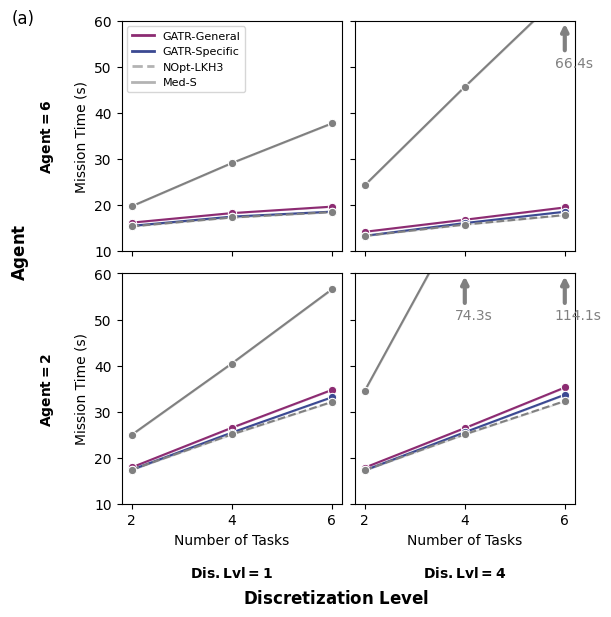

In [7]:
def transform_df(df, num_agent = 2, discretize_level = 1):
    df = df[(df["num_agent"] == num_agent)  & (df["discretize_level"] == discretize_level)]
    df["num_node"] = df["num_task"]*df["discretize_level"]
    df["Method"] = df["method"].replace(method_presentable, inplace=False)
    return df

fig, axes = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)

for row, num_agent in enumerate([6, 2]):
    for col, discretize_level in enumerate([1, 4]):
        ax = axes[row, col]
        df = transform_df(MERGED_DF, num_agent=num_agent, discretize_level=discretize_level)
        sns.lineplot(
            data=df, 
            x="num_task", 
            y="mission_time", 
            hue="Method",
            marker='o',
            ax=ax,
            errorbar=("se", 2),
            hue_order=[method_presentable["gat_gen"],method_presentable["gat"],method_presentable["lkh"], method_presentable["random"]],
            palette=[CB_color_cycle_hex[0], CB_color_cycle_hex[1], "grey", "grey"]
        )

        # Define custom linestyles for each Method
        linestyles = {
            method_presentable["gat_gen"]: "solid",
            method_presentable["gat"]: "solid",
            method_presentable["lkh"]: "dashed",
            method_presentable["random"]: "solid"
        }
        # Iterate over lines and set custom linestyles
        for line, method in zip(ax.get_lines(), method_presentable.values()):
            line.set_linestyle(linestyles[method])
        
        ax.legend().remove()
        legend_elements = [Line2D([0], [0], color=palette[0], lw=2,linestyle="solid", label=method_presentable["gat_gen"]),
                           Line2D([0], [0], color=palette[1], lw=2,linestyle="solid", label=method_presentable["gat"]),
                           Line2D([0], [0], color=palette[7], lw=2,linestyle="dashed", label=method_presentable["lkh"]),
                           Line2D([0], [0], color=palette[7], lw=2,linestyle="solid", label=method_presentable["random"]),]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=8)

        xticks = df["num_task"].unique()
        ax.set_xticks(xticks)
        ax.set_ylim(10, 60)

        if col == 0 and row == 0:
            # ax.text(x=-1,y=60,s="(a)",fontsize = 12)
            pass
        else:
            ax.legend().remove()

        if num_agent == 2 and discretize_level == 4:
            ax.annotate("", xy=(4, 53), xytext=(4, 60), arrowprops=dict(arrowstyle="<-", lw=3, color='grey'))
            ax.text(3.8, 50, "74.3s", fontsize=10, color='grey')
            ax.annotate("", xy=(6, 53), xytext=(6, 60), arrowprops=dict(arrowstyle="<-", lw=3, color='grey'))
            ax.text(5.8, 50, "114.1s", fontsize=10, color='grey')

        if num_agent == 6 and discretize_level == 4:
            ax.annotate("", xy=(6, 53), xytext=(6, 60), arrowprops=dict(arrowstyle="<-", lw=3, color='grey'))
            ax.text(5.8, 50, "66.4s", fontsize=10, color='grey')

        if (col == 0):
            ax.set_ylabel(r"$\mathbf{Agent=" + str(num_agent) + "}$" + "\n\nMission Time (s)")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel("")

        if (row == 1):
            ax.set_xlabel("Number of Tasks\n\n" + r"$\mathbf{Dis. Lvl=" + str(discretize_level) + "}$")
        else:
            ax.set_xticklabels([])
            ax.set_xlabel("")

fig.supylabel(r"$\mathbf{Agent}$", y=0.6)
fig.supxlabel(r"$\mathbf{Discretization\ Level}$", x=0.55)
fig.text(x=0.01, y=0.98, s="(a)", fontsize=12, transform=fig.transFigure)
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
plt.savefig("../../cache/plots/result2_a.png", bbox_inches='tight', dpi=500)

In [8]:
def transform_df(df):
    method3 = "random"
    method2 = "gat_gen"
    method1 = "gat"
    against = "lkh"

    df = df[(df["exp_size"] == 10000)]
    df = df[["method", "num_agent", "num_task", "discretize_level", "mission_time", "seed", "exp_idx", "runtime"]]
    out_method3 = df[(df["method"]==method3)]
    out_method2 = df[(df["method"]==method2)]
    out_method1 = df[(df["method"]==method1)]
    out_against = df[(df["method"]==against)]

    combined = pd.merge(out_method3, out_against, how='left', on=["num_agent", "num_task", "discretize_level", "seed", "exp_idx"], suffixes=("_random", "_lkh"))
    
    combined_gat_gen = pd.merge(out_method2, combined, how='left', 
                        on=["num_agent", "num_task", "discretize_level", "seed", "exp_idx"])
    out_method2["gap"] = (combined_gat_gen["mission_time"].values - combined_gat_gen["mission_time_lkh"].values)*100/combined_gat_gen["mission_time_lkh"].values
    
    combined_gat = pd.merge(out_method1, combined, how='left', 
                        on=["num_agent", "num_task", "discretize_level", "seed", "exp_idx"])
    out_method1["gap"] = (combined_gat["mission_time"].values - combined_gat["mission_time_lkh"].values)*100/combined_gat["mission_time_lkh"].values

    output = pd.concat([out_method2, out_method1], ignore_index=True)
    output["num_node"] = output["num_task"]*output["discretize_level"]
    output["ratio"] = output["num_task"]*output["discretize_level"] / output["num_agent"]
    output["ratio"] = output["ratio"].round(2)
    output["Method"] = output["method"].replace(method_presentable, inplace=False)
    return output

def transform_df_runtime(df, num_agent = 2):
    method2 = "gat_gen"
    against = "lkh"

    df = df[(df["exp_size"] == 1000)]
    df = df[(df["num_agent"] == num_agent)]
    df = df[["Machine", "method", "num_agent", "num_task", "discretize_level", "mission_time", "seed", "exp_idx", "runtime"]]

    out_method2 = df[(df["method"]==method2)]
    out_against = df[(df["method"]==against)]

    combined_gat_gen = pd.merge(out_method2, out_against, how='left', 
                        on=["num_agent", "num_task", "discretize_level", "seed", "exp_idx", "Machine"], suffixes=("", "_lkh"))
    out_method2["gap"] = combined_gat_gen["runtime"].values*100/(combined_gat_gen["runtime_lkh"].values)
    out_method2["method"] = method2

    output = out_method2
    output["num_node"] = output["num_task"]*output["discretize_level"]
    output["ratio"] = output["num_task"]*output["discretize_level"]/output["num_agent"]
    output["ratio"] = output["ratio"].round(2)
    output["Method"] = output["method"].replace(method_presentable, inplace=False)
    return output

def get_xy(df, method=None, machine=None):
    if method is not None:
        df = df[(df["Method"] == method)] 
    if machine is not None:
        df = df[(df["Machine"] == machine)]

    grouped_df = df.groupby(['ratio']).agg({
        'gap': ['mean', 'sem']
    }).round(3)
    grouped_df = grouped_df.reset_index()
    x = grouped_df.xs('mean', level=1, axis=1).values.flatten()
    x_error = grouped_df.xs('sem', level=1, axis=1).values.flatten()
    y = grouped_df.xs('ratio', level=0, axis=1).values.flatten()
    return x, x_error, y

/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_9475/2536099305.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_method2["gap"] = (combined_gat_gen["mission_time"].values - combined_gat_gen["mission_time_lkh"].values)*100/combined_gat_gen["mission_time_lkh"].values
/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_9475/2536099305.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_method1["gap"] = (combined_gat["mission_time"].values - combined_gat["mission_time_lkh"].values

gpu agent: 4 num node: [1.5 3.  6. ] runtime [11.108  6.339  3.7  ] method_presentable[gat_gen] GATR-General
pi agent: 4 num node: [1.5 3.  6. ] runtime [1.178 0.577 0.325] method_presentable[gat_gen] GATR-General
gpu agent: 6 num node: [1. 2. 4.] runtime [7.966 5.381 3.375] method_presentable[gat_gen] GATR-General
pi agent: 6 num node: [1. 2. 4.] runtime [0.666 0.441 0.275] method_presentable[gat_gen] GATR-General


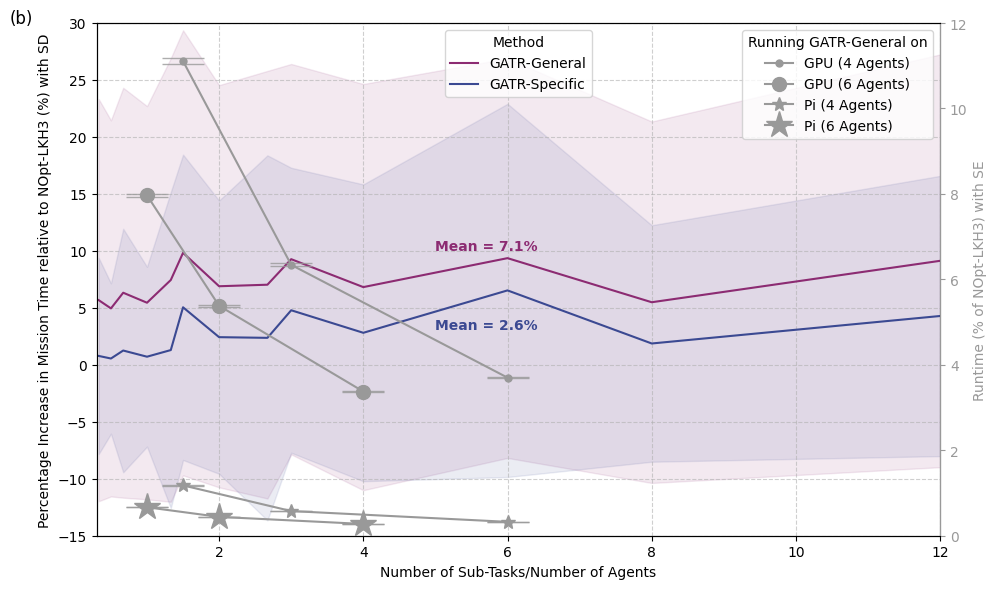

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
df = transform_df(MERGED_DF)
sns.lineplot(
    data=df, 
    x="ratio", 
    y="gap", 
    hue="Method",
    # style="discretize_level",
    markers=True,
    ax=ax,
    errorbar=("sd", 2),
    palette=palette,  # Use a distinct color palette
)
ax.legend(loc="upper center", fontsize=10, frameon=True, title="Method")

# Reduce the alpha of error bars
for line in ax.collections:  # Axes collections include error bar fills
    if isinstance(line, PolyCollection):  # Error bars are PolyCollections
        line.set_alpha(0.1)  # Adjust alpha here (e.g., 0.3 for reduced opacity)
        # line.set_alpha(0)  # Make SD disappear

# Plot average line
for idx, m in enumerate([method_presentable["gat_gen"], method_presentable["gat"]]):
    val = df.groupby("Method")["gap"].mean()[m]
    val =  val.round(1)
    # if m == method_presentable["gat"]:
    if m == method_presentable["gat_gen"]:
        offset = 3
    elif m == method_presentable["gat"]:
        offset = 0.5
    ax.text(5, val+offset, f"Mean = {val}%", fontsize=10, color=CB_color_cycle_hex[idx], weight='bold')

num_agents = {4: 10, 6: 20}  # Dictionary mapping num_agent to marker size
machines = [("gpu", '.', 15, 1), ("pi", '*', 15, 1)]
runtime_plot_color = CB_color_cycle_hex[6]
runtime_error_plot_color = CB_color_cycle_hex[7]
for num_agent, marker_size in num_agents.items():
    df_runtime = transform_df_runtime(MERGED_DF, num_agent=num_agent)
    for machine, fmt, capsize, capthick in machines:
        x, x_error, y = get_xy(df_runtime, method=method_presentable["gat_gen"], machine=machine)
        print(machine, "agent:", num_agent, "num node:", y, "runtime", x, "method_presentable[gat_gen]", method_presentable["gat_gen"])
        ax2.errorbar(y, x, x_error, c=runtime_plot_color, fmt=fmt, capsize=capsize, capthick=capthick, alpha=0.8)
        ax2.plot(y, x, c=runtime_plot_color, marker=fmt, markersize=marker_size, linestyle='-', linewidth=1.5)
ax2.spines['right'].set_color(runtime_plot_color)
ax2.tick_params(axis='y', colors=runtime_plot_color)
ax2.yaxis.label.set_color(runtime_plot_color)

legend_elements = [
    Line2D([0], [0], color=runtime_plot_color , marker='.', linestyle='-', linewidth=1.5, markersize=10, label="GPU (4 Agents)"),
    Line2D([0], [0], color=runtime_plot_color , marker='.', linestyle='-', linewidth=1.5, markersize=20, label="GPU (6 Agents)"),
    Line2D([0], [0], color=runtime_plot_color , marker='*', linestyle='-', linewidth=1.5, markersize=10, label="Pi (4 Agents)"),
    Line2D([0], [0], color=runtime_plot_color , marker='*', linestyle='-', linewidth=1.5, markersize=20, label="Pi (6 Agents)"),
]
legend2 = ax2.legend(handles=legend_elements, loc="upper right", fontsize=10, frameon=True, title=f"Running {method_presentable['gat_gen']} on")


ax.set_ylabel(f"Percentage Increase in Mission Time relative to {method_presentable['lkh']} (%) with SD")
ax.set_xlabel("Number of Sub-Tasks/Number of Agents")
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xlim(0.3, 12)
ax.set_ylim(-15, 30)
ax2.set_ylabel(f"Runtime (% of {method_presentable['lkh']}) with SE")
ax2.set_ylim(0, 12)
ax.text(x=-0.9,y=30,s="(b)",fontsize = 12)
plt.tight_layout()
fig.savefig("../../cache/plots/result2_b.png", bbox_inches='tight', dpi=500)